In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import random
import numpy as np
from sklearn.utils import shuffle
from tensorflow import keras
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, classification_report

Note: Code to be run only in Kaggle notebook, due to predefined paths of data directories. Find the dataset link here: [**DataSet Link**](https://www.kaggle.com/datasets/soumikrakshit/ade20k?datasetId=784880&sortBy=dateRun&tab=profile)

# Creating training and validation directories.
* Training on 6 classes of rooms: 'bedroom', 'childs_room', 'dining_room', 'hallway', 'kitchen', 'living_room'

In [3]:
train_dir = '../input/ade20k/ADE20K_2016_07_26/images/training'
val_dir = '../input/ade20k/ADE20K_2016_07_26/images/validation'
classes = ["classroom", "lab_classroom", "lecture_room","conference_room","computer_room",
                   "beach","dam","playground","bus_shelter","crosswalk","skyscraper","highway",
                   "downtown", "farm", "hospital", "police_station",
                   "railroad_track","street","town_house","excavation","industrial_area",
                   "mountain","corridor","landfill","cliff","hill","skyscraper","coast","park","bridge","house"]
label2idx = {label : idx for idx, label in enumerate(classes)}
idx2label = {val : key for key, val in label2idx.items()}

In [29]:
idx2label

{0: 'classroom',
 1: 'lab_classroom',
 2: 'lecture_room',
 3: 'conference_room',
 4: 'computer_room',
 5: 'beach',
 6: 'dam',
 7: 'playground',
 8: 'bus_shelter',
 9: 'crosswalk',
 26: 'skyscraper',
 11: 'highway',
 12: 'downtown',
 13: 'farm',
 14: 'hospital',
 15: 'police_station',
 16: 'railroad_track',
 17: 'street',
 18: 'town_house',
 19: 'excavation',
 20: 'industrial_area',
 21: 'mountain',
 22: 'corridor',
 23: 'landfill',
 24: 'cliff',
 25: 'hill',
 27: 'coast',
 28: 'park',
 29: 'bridge',
 30: 'house'}

In [4]:
os.mkdir('/kaggle/working/dataset')

In [11]:
def create_train_dir(train_dir):
    if not os.path.exists(os.path.join('/kaggle/working/dataset/train')):
             os.mkdir('/kaggle/working/dataset/train')
    for label in classes:
        if not os.path.exists(os.path.join('/kaggle/working/dataset/train/'+label)):
            os.mkdir('/kaggle/working/dataset/train/'+label)
        for file in os.listdir(train_dir+'/'+label[0]+'/'+label):
            if file.endswith('.jpg'):
                with open(train_dir+'/'+label[0]+'/'+label+'/'+file, 'rb') as f:
                    file_data = f.read()
                with open('/kaggle/working/dataset/train/'+label+'/'+file, 'wb+') as f:
                    f.write(file_data)
                #shutil.copy2(train_dir+'/'+label[0]+'/'+label+'/'+file, '/kaggle/working/dataset/train/'+label)

In [17]:
def create_val_dir(val_dir):
    if not os.path.exists(os.path.join('/kaggle/working/dataset/validation')):
             os.mkdir('/kaggle/working/dataset/validation')
    
    for label in classes:
        if not os.path.exists(os.path.join('/kaggle/working/dataset/validation/'+label)):
            os.mkdir('/kaggle/working/dataset/validation/'+label)
            
        if os.path.exists(os.path.join(val_dir+'/'+label[0]+'/'+label)):
            for file in os.listdir(val_dir+'/'+label[0]+'/'+label):
                if file.endswith('.jpg'):
                    if os.path.exists(os.path.join(val_dir+'/'+label[0]+'/'+label+'/'+file)):
                        with open(val_dir+'/'+label[0]+'/'+label+'/'+file, 'rb') as f:
                            file_data = f.read()
                        with open('/kaggle/working/dataset/validation/'+label+'/'+file, 'wb+') as f:
                            f.write(file_data)
                    
                

In [12]:
create_train_dir(train_dir)


In [18]:
create_val_dir(val_dir)

# Loading train and val images using OpenCV, without augmentation.

In [39]:
def get_images_labels(input_dir):
    images = []
    labels = []
    for label_folder in os.listdir(input_dir):
        for img in os.listdir(input_dir+'/'+label_folder):
            image = cv2.imread(input_dir+'/'+label_folder+'/'+img)
            image = cv2.resize(image, (224,224))
            images.append(image)
            labels.append(label2idx[label_folder])
    return shuffle(images, labels, random_state=42)

train_images, train_labels = get_images_labels('/kaggle/working/dataset/train')
val_images, val_labels = get_images_labels('/kaggle/working/dataset/validation/')
train_images = np.array(train_images)*(1. / 255)
train_labels = np.array(train_labels)
val_images = np.array(val_images)*(1./255)
val_labels = np.array(val_labels)

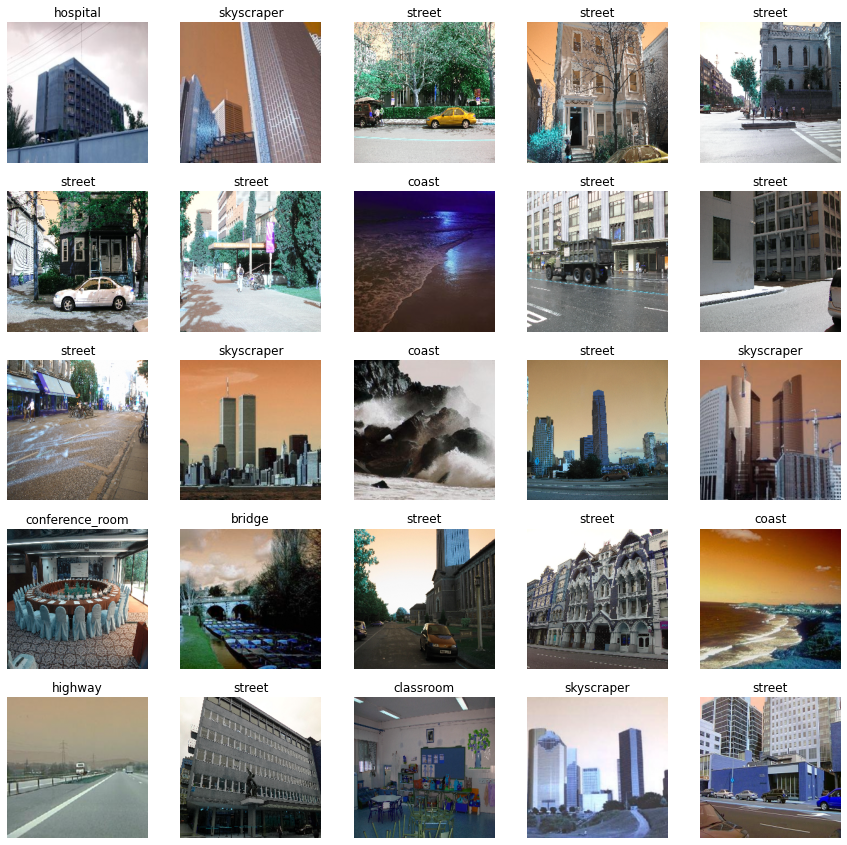

In [41]:
#Plot random images from above train set.
fig, ax = plt.subplots(5,5, figsize=(15,15))
for i in range(5):
    for j in range(5):
        rand_int = random.randint(0, len(train_images))
        ax[i][j].imshow(train_images[rand_int])
        ax[i][j].set_title(idx2label[train_labels[rand_int]])
        ax[i][j].axis('off')

# Alternately, load images with Augmentation directly from directory.

In [19]:
train_datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2,
                                  zoom_range=0.2, horizontal_flip=True, fill_mode='constant', cval=125, 
                                  preprocessing_function=keras.applications.mobilenet.preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input)

train_generator = train_datagen.flow_from_directory(
                    directory='/kaggle/working/dataset/train',
                    target_size=(224,224),
                    color_mode='rgb',
                    class_mode='categorical', # for categorical_crossentropy loss. Use 'sparse' for sparse loss
                    batch_size=32                  
                )
val_generator = val_datagen.flow_from_directory(
                    directory='/kaggle/working/dataset/validation',
                    target_size=(224,224),
                    color_mode='rgb',
                    class_mode='categorical', 
                    batch_size=32
                )
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

Found 3624 images belonging to 30 classes.
Found 361 images belonging to 30 classes.


# Using MobileNet v2 pretrained on ImageNet on augmented data

In [22]:
mobilenet = MobileNetV2(include_top=False, input_shape=(224,224,3), weights='imagenet')
for layer in mobilenet.layers:
    layer.trainable = False

model = GlobalAveragePooling2D()(mobilenet.output)
model = keras.layers.Dense(1024, activation='relu')(model)
model = keras.layers.Dropout(0.3)(model)
model = keras.layers.Dense(1024, activation='relu')(model)
model = keras.layers.Dense(30, activation='softmax')(model)
mobilenet_model = Model(inputs = mobilenet.input, outputs = model)
mobilenet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

In [23]:
#Model training. Use the commented code for training if using non-augmented data instead.
mobilenet_model.compile(optimizer=keras.optimizers.Adam(learning_rate=2e-5), 
                        loss='categorical_crossentropy', 
                        metrics=['accuracy', 
                                 keras.metrics.Precision(name='precision'), 
                                 keras.metrics.Recall(name='recall'), 
                                 keras.metrics.AUC(name='auc')])
"""history = mobilenet_model.fit(train_images, keras.utils.to_categorical(train_labels, num_classes=6), 
                              validation_data=(val_images, keras.utils.to_categorical(val_labels, num_classes=6)), 
                              epochs=30, batch_size=32)"""

history = mobilenet_model.fit_generator(train_generator, 
                              epochs=10, 
                              steps_per_epoch=train_generator.n // train_generator.batch_size,
                              validation_data=val_generator,
                              validation_steps=val_generator.n // val_generator.batch_size,
                              callbacks=[callback])

Epoch 1/10
113/113 [==============================] - 146s 1s/step - loss: 1.7785 - accuracy: 0.5699 - precision: 0.7841 - recall: 0.4268 - auc: 0.9053 - val_loss: 1.1711 - val_accuracy: 0.6847 - val_precision: 0.8904 - val_recall: 0.5767 - val_auc: 0.9625
Epoch 2/10
113/113 [==============================] - 143s 1s/step - loss: 1.1083 - accuracy: 0.7174 - precision: 0.9102 - recall: 0.5980 - auc: 0.9624 - val_loss: 0.8658 - val_accuracy: 0.7557 - val_precision: 0.9029 - val_recall: 0.7131 - val_auc: 0.9745
Epoch 3/10
113/113 [==============================] - 141s 1s/step - loss: 0.8602 - accuracy: 0.7976 - precision: 0.9253 - recall: 0.6729 - auc: 0.9751 - val_loss: 0.6654 - val_accuracy: 0.8239 - val_precision: 0.9066 - val_recall: 0.7443 - val_auc: 0.9821
Epoch 4/10
113/113 [==============================] - 140s 1s/step - loss: 0.7200 - accuracy: 0.8318 - precision: 0.9265 - recall: 0.7261 - auc: 0.9813 - val_loss: 0.5600 - val_accuracy: 0.8608 - val_precision: 0.9272 - val_recal

In [24]:
mobilenet_model.save('ade20k_scene_parsing_classifier.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [25]:
def plot_diagnostics(history, epochs):
    fig, ax = plt.subplots(1,2, figsize=(15,5))
    ax[0].plot(range(epochs), history['loss'], label='Training Loss')
    ax[0].plot(range(epochs), history['val_loss'], label='Validation Loss')
    ax[0].set_title('Loss Curves')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    ax[1].plot(range(epochs), history['accuracy'], label='Training Accuracy')
    ax[1].plot(range(epochs), history['val_accuracy'], label='Validation Accuracy')
    ax[1].set_title('Accuracy Curves')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()

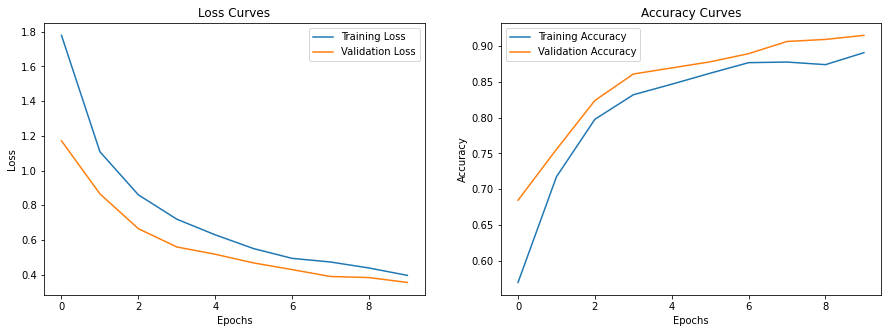

In [26]:
plot_diagnostics(history.history, len(history.history['loss']))

In [27]:
#Get results on validation data. Use commented code, if trained on non-augmented images.
#y_prob = mobilenet_model.predict(val_images)
y_prob = mobilenet_model.predict_generator(val_generator)
y_pred = np.argmax(y_prob, axis=-1)


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [32]:
y_pred

array([28, 14, 28, 28,  5, 22, 28, 14, 28, 28, 28,  7, 24, 28, 28, 28, 28,
       28, 28, 28, 27, 27, 28, 28, 14, 14,  3, 27, 27, 14,  7,  7, 28, 28,
       28, 28, 28, 28, 28, 28, 28, 28, 28,  7,  7, 28, 15,  8, 28,  7, 28,
       28, 28, 27, 27, 28, 28, 28,  7, 28, 28, 28,  5, 28, 28, 28, 28,  7,
       28, 28,  7, 28, 14, 24, 28, 28, 27, 28, 15, 28, 28, 28,  7,  7, 12,
        5, 14,  3, 28, 28, 28, 27, 28, 28, 28, 28, 28, 28, 23, 23, 28,  0,
       27, 28, 24, 28, 28, 28, 27, 28, 28,  7, 28, 28,  8, 28, 27, 28, 28,
       28, 28,  3, 14, 28, 14, 14, 28, 28, 28, 28, 28,  3, 28, 17, 14, 14,
       28, 28, 28, 28, 28,  7, 28,  8, 28, 28, 28, 14,  8, 28, 15, 28, 28,
       28, 14, 28, 27,  8, 28, 23, 28,  8, 14, 27, 28, 17, 28, 27, 28, 28,
       27, 28,  0, 28, 28, 28, 28, 28, 28, 28, 14, 28, 27, 28, 23, 28, 28,
       28,  8, 28, 22, 28, 28, 28, 17, 28,  1, 22, 28, 28, 28, 14, 28, 27,
       28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28,  8,  5, 28, 14,  6, 28,
        1, 28, 28, 28, 14

In [33]:
y_prob

array([[9.0326625e-07, 2.2679652e-04, 1.3947565e-04, ..., 6.0132156e-06,
        9.9812418e-01, 3.8744845e-05],
       [1.5529640e-05, 5.6531437e-05, 4.0054256e-06, ..., 2.0343323e-05,
        5.9892770e-02, 1.5267457e-05],
       [9.7841724e-10, 9.3641319e-08, 6.9808735e-08, ..., 1.3589668e-07,
        9.9999416e-01, 3.7315834e-07],
       ...,
       [6.4950790e-03, 2.9602465e-03, 9.5021894e-04, ..., 2.0989518e-04,
        4.0264317e-04, 7.8779180e-04],
       [5.9664446e-05, 1.0387094e-04, 3.3945011e-04, ..., 9.0381582e-05,
        9.1460848e-01, 1.3108490e-03],
       [3.5807406e-09, 1.1258665e-07, 1.5561632e-07, ..., 4.0781430e-08,
        9.9998713e-01, 1.6944817e-07]], dtype=float32)

In [44]:
val_labels 

array([17, 17, 17,  5, 17, 17, 17, 17,  3, 17,  2, 17, 26, 17, 17, 17, 26,
       27,  5, 17, 21, 17, 17, 11, 22, 17,  9, 17, 17, 20, 17, 17, 17,  7,
       17, 17, 17, 17, 11, 17, 26, 29, 17, 11, 17, 29, 17, 17,  0, 17, 26,
       17,  3, 17, 17, 22, 17,  0, 11, 17, 22, 26, 17, 17,  3, 17, 27, 17,
       11, 17, 17, 13, 11, 17, 22, 28, 17, 17, 28, 17, 17,  3, 21, 17, 17,
        8, 30, 11, 22, 17, 11, 17, 17, 11, 17, 27, 17, 17, 17, 17, 17, 30,
       28, 17, 17, 17, 26, 28, 11, 17, 12, 27,  3, 17,  5, 17, 26, 17,  3,
       17, 11, 17, 17, 17, 17, 17, 17, 18, 17, 11, 17, 17, 17, 17, 21, 25,
       26, 21, 17, 17, 17, 11, 26, 17, 17, 26, 17, 17, 17,  5, 17, 17,  3,
       17, 17, 17, 17, 17, 17, 17, 17,  4, 27, 11, 26, 17, 17, 17, 17, 11,
       30, 11, 14,  3, 17, 29, 17, 26, 17, 17, 21, 26, 17, 17, 17, 11, 27,
       17, 22,  6, 25,  5, 17, 26, 26, 17, 26,  0, 17, 17, 26, 26, 17,  3,
       17, 11, 17, 17, 11, 17, 17, 11, 17, 11, 26, 17, 17, 22, 17, 22, 17,
       11, 17, 17, 17, 17

In [34]:
np.argmax(test_labels, axis=-1)

0

In [45]:
print(f'Overall Validation Accuracy: {accuracy_score(np.argmax(val_labels, axis=-1), y_pred)}')
print('Overall Validation Precision:', precision_score(np.argmax(val_labels, axis=-1), y_pred, average='weighted', zero_division=0))
print('Overall Validation Recall:', recall_score(np.argmax(val_labels, axis=-1), y_pred, average='weighted', zero_division=0))
print('Overall Validation AUC:', roc_auc_score(np.argmax(val_labels, axis=-1), y_prob, multi_class='ovo'))

TypeError: Singleton array 86 cannot be considered a valid collection.

In [46]:
print(classification_report(val_labels, y_pred, target_names=classes, zero_division=0))

ValueError: Number of classes, 29, does not match size of target_names, 31. Try specifying the labels parameter